In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.dates as mdates
import matplotlib.ticker as ab

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading files
folder_path = '/content/drive/MyDrive/sp500_tickers_A-D_1min_1pppix'
file_path = '/content/drive/MyDrive/sp500_tickers_A-D_1min_1pppix/AMZN_1min.txt'
files_in_folder = os.listdir(folder_path)

with open(file_path, 'r') as file:
    content = file.read()

In [4]:
# splitiing each line to different columns
Columns = []
with open(file_path, 'r') as file:
    for line in file:
        line = line.replace(' ', ',')
        columns = line.strip().split(',')
        Columns.append(columns)
data = np.array(Columns)
stock1 = pd.DataFrame(data)
columns_ = ['Date', 'Time', 'Open', 'High', 'Low', 'Close','Volume Traded']
stock1.columns = columns_
stock1.head()

,Date,Time,Open,High,Low,Close,Volume Traded
0,2005-01-03,08:00:00,44.56,45.14,44.56,44.75,2322
1,2005-01-03,08:01:00,45.13,45.3,45.08,45.1,5426
2,2005-01-03,08:02:00,45.3,45.35,45.3,45.35,400
3,2005-01-03,08:03:00,45.35,45.35,45.3,45.35,2000
4,2005-01-03,08:04:00,45.35,45.58,45.3,45.55,3750


In [5]:
# Converting Date and Time column to datetime type
stock1['Date'] = pd.to_datetime(stock1['Date'])
stock1['Time'] = pd.to_datetime(stock1['Time'], format='%H:%M:%S').dt.time      #without .dt.time today's date and time were coming together
stock1.head()

,Date,Time,Open,High,Low,Close,Volume Traded
0,2005-01-03,08:00:00,44.56,45.14,44.56,44.75,2322
1,2005-01-03,08:01:00,45.13,45.3,45.08,45.1,5426
2,2005-01-03,08:02:00,45.3,45.35,45.3,45.35,400
3,2005-01-03,08:03:00,45.35,45.35,45.3,45.35,2000
4,2005-01-03,08:04:00,45.35,45.58,45.3,45.55,3750


In [6]:
# removing the data outside of stock market run time
start_time = pd.to_datetime('09:30:00').time()
end_time = pd.to_datetime('15:59:59').time()

stock1_f = stock1[(stock1['Time'] >= start_time) & (stock1['Time'] <= end_time)]
stock1_f.head(390)

,Date,Time,Open,High,Low,Close,Volume Traded
58,2005-01-03,09:30:00,44.95,45.15,44.91,45.11,167005
59,2005-01-03,09:31:00,45.11,45.15,45.0,45.1,73739
60,2005-01-03,09:32:00,45.1,45.15,45.03,45.09,75816
61,2005-01-03,09:33:00,45.08,45.11,45.03,45.11,115016
62,2005-01-03,09:34:00,45.11,45.19,45.08,45.09,86538
...,...,...,...,...,...,...,...
443,2005-01-03,15:55:00,44.35,44.43,44.35,44.41,37465
444,2005-01-03,15:56:00,44.41,44.45,44.4,44.45,37711
445,2005-01-03,15:57:00,44.46,44.56,44.46,44.54,55913
446,2005-01-03,15:58:00,44.55,44.59,44.54,44.59,30932


In [7]:
stock1_f['Time'] = stock1_f['Time'].apply(str)
stock1_f.set_index('Date', inplace=True)
stock1_f.head(385)

<ipython-input-7-b0806db2b21e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1_f['Time'] = stock1_f['Time'].apply(str)


,Time,Open,High,Low,Close,Volume Traded
Date,,,,,,
2005-01-03,09:30:00,44.95,45.15,44.91,45.11,167005
2005-01-03,09:31:00,45.11,45.15,45.0,45.1,73739
2005-01-03,09:32:00,45.1,45.15,45.03,45.09,75816
2005-01-03,09:33:00,45.08,45.11,45.03,45.11,115016
2005-01-03,09:34:00,45.11,45.19,45.08,45.09,86538
...,...,...,...,...,...,...
2005-01-03,15:50:00,44.45,44.47,44.41,44.43,51365
2005-01-03,15:51:00,44.44,44.44,44.41,44.43,57834
2005-01-03,15:52:00,44.43,44.44,44.39,44.39,45850


In [10]:
i = 0
# Create an empty list to store DataFrames
df = []
files = ['AMG_1min.txt','AMGN_1min.txt','AMP_1min.txt','AMT_1min.txt','AMZN_1min.txt']
# Loop through each file in the folder
for file in files:
    # Read the CSV file into a DataFrame and specify column names
    df.append(pd.read_csv('/content/drive/MyDrive/sp500_tickers_A-D_1min_1pppix' + '/' + file, sep=',', header=None, names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']))

    # Split the 'DateTime' column into separate 'Date' and 'Time' columns
    df[i][['Date', 'Time']] = df[i]['DateTime'].str.split(' ', expand=True)

    # Drop the 'DateTime' column
    df[i].drop(columns=['DateTime'], inplace=True)

    # Set the 'Date' column as the index
    df[i]['Date'] = pd.to_datetime(df[i]['Date'])
    df[i]['Time'] = pd.to_datetime(df[i]['Time'], format='%H:%M:%S').dt.time
    # removing the data outside of stock market run time
    start_time = pd.to_datetime('09:30:00').time()
    end_time = pd.to_datetime('15:59:59').time()

    df[i] = df[i][(df[i]['Time'] >= start_time) & (df[i]['Time'] <= end_time)]
    df[i]['Time'] = df[i]['Time'].apply(str)

    df[i].set_index('Date', inplace=True)
    i += 1

    # Break the loop after processing 4 files
    if i == 5:
        break


In [11]:
df[0]

,Open,High,Low,Close,Volume,Time
Date,,,,,,
2005-01-03,65.3131,65.3616,65.3131,65.3616,6900,09:30:00
2005-01-03,65.3616,65.3616,65.3616,65.3616,600,09:31:00
2005-01-03,65.3713,65.5069,65.3713,65.5069,700,09:32:00
2005-01-03,65.4875,65.5069,65.4875,65.5069,200,09:33:00
2005-01-03,65.5554,65.5554,65.5554,65.5554,200,09:34:00
...,...,...,...,...,...,...
2022-02-25,141.4600,141.7000,141.3950,141.7000,1500,15:55:00
2022-02-25,141.5700,141.5700,141.3600,141.5000,675,15:56:00
2022-02-25,141.5200,141.5500,141.3900,141.5000,952,15:57:00


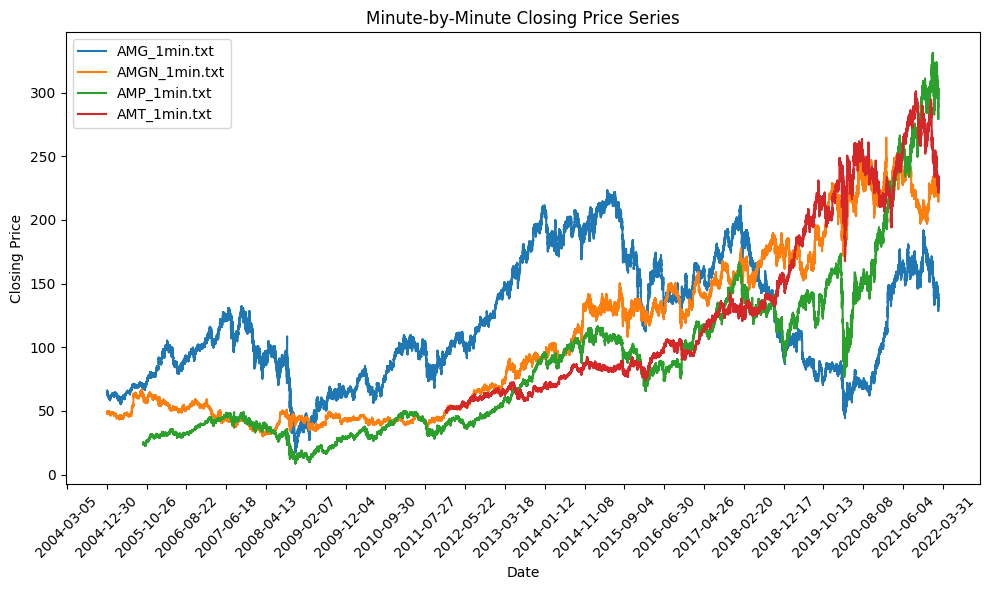

In [12]:
# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Iterating through 4 stocks and plotting their closing price per minute
for i in range(4):
    # Plotting the closing price for the i-th stock
    plt.plot(df[i].index, df[i]['Close'], label=files[i], linestyle='-')
    date_format = mdates.DateFormatter("%Y-%m-%d")  # Define the date format, adjust as needed
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))  # Display dates at equal intervals
    plt.gca().xaxis.set_major_formatter(date_format)  # Apply the date format

    plt.legend()
    plt.title('Minute-by-Minute Closing Price Series')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()


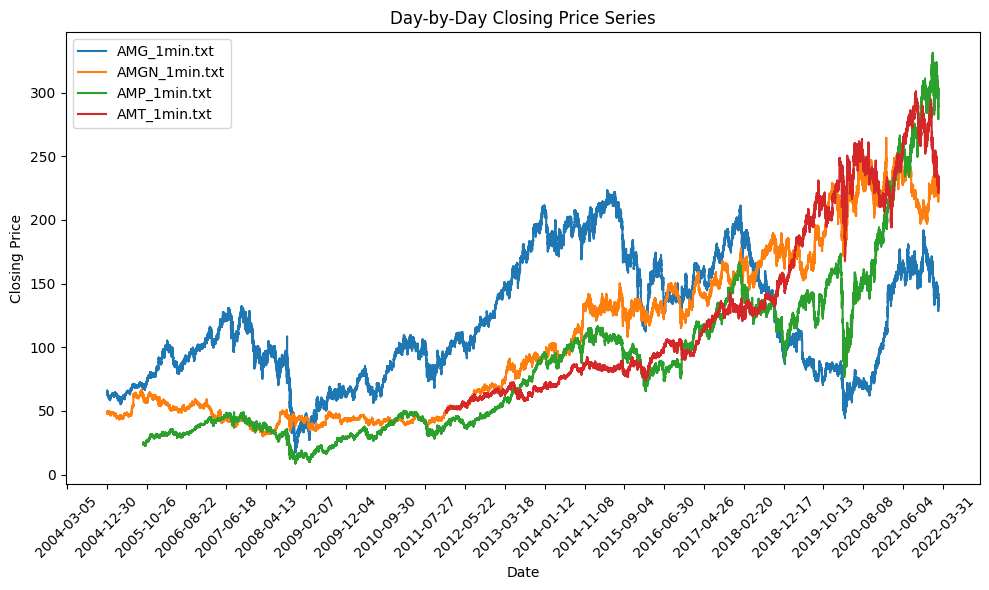

In [13]:
# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Iterating through 4 stocks and plotting their closing price per minute
for i in range(4):
    # Plotting the closing price for the i-th stock
    plt.plot(df[i].index, df[i]['Close'], label=files[i], linestyle='-')
    date_format = mdates.DateFormatter("%Y-%m-%d")  # Define the date format, adjust as needed
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))  # Display dates at equal intervals
    plt.gca().xaxis.set_major_formatter(date_format)  # Apply the date format

    plt.legend()
    plt.title('Day-by-Day Closing Price Series')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()


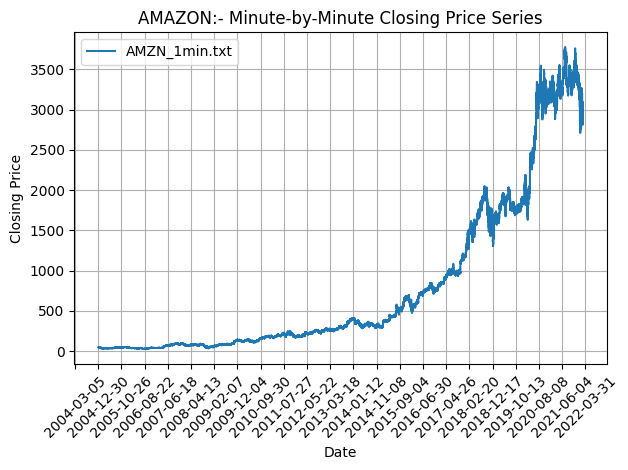

In [14]:
# Plotting min by min stock data for amazon
i = 4
plt.plot(df[i].index, df[i]['Close'], label=files[i], linestyle='-')
date_format = mdates.DateFormatter("%Y-%m-%d")  # Define the date format, adjust as needed
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=300))  # Display dates at equal intervals
plt.gca().xaxis.set_major_formatter(date_format)  # Apply the date format

plt.legend()
plt.title('AMAZON:- Minute-by-Minute Closing Price Series')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

In [15]:
#stock1_day is the df with only the closing price for that day
stock1_day_all = stock1_f.groupby('Date')['Time','Open', 'High', 'Low', 'Close','Volume Traded'].last().reset_index()
stock1_day = stock1_f.groupby('Date')['Close'].last().reset_index()
stock1_day

<ipython-input-15-b28e5d0bce0d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stock1_day_all = stock1_f.groupby('Date')['Time','Open', 'High', 'Low', 'Close','Volume Traded'].last().reset_index()


,Date,Close
0,2005-01-03,44.46
1,2005-01-04,42.22
2,2005-01-05,41.76
3,2005-01-06,41.05
4,2005-01-07,42.36
...,...,...
4313,2022-02-18,3053.4200
4314,2022-02-22,3005.3200
4315,2022-02-23,2896.5400
4316,2022-02-24,3026.9700


In [16]:
# Resample to daily OHLC data
daily_ohlc = stock1_f.resample('D').agg({
    'Open': 'first',   # First price of the day is the open
    'High': 'max',     # Maximum price of the day is the high
    'Low': 'min',      # Minimum price of the day is the low
    'Close': 'last'    # Last price of the day is the close
})

# Display the daily OHLC data
daily_ohlc

,Open,High,Low,Close
Date,,,,
2005-01-03,44.95,45.44,44.21,44.46
2005-01-04,42.62,43.26,41.5,42.22
2005-01-05,41.57,42.76,41.56,41.76
2005-01-06,41.81,42.25,40.9,41.05
2005-01-07,41.33,42.69,41.16,42.36
...,...,...,...,...
2022-02-21,None,NaN,NaN,None
2022-02-22,3011.5400,3059.6500,2969.7100,3005.3200
2022-02-23,3033.0100,3035.2600,2893.0200,2896.5400


In [17]:
# Create a candlestick chart using Plotly
stockcandle = stock1_f[:385]
fig = go.Figure(data=[go.Candlestick(
    x= stockcandle['Time'],
    open=stockcandle['Open'],
    high=stockcandle['High'],
    low=stockcandle['Low'],
    close=stockcandle['Close']
)])

# Customize the layout
fig.update_layout(
    title='Candlestick Chart for Amazon Stock(per min)- Day1',
    xaxis_title='Date and Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=True,
    width=1200,  # Set the figure width (in pixels)
    height=700
)

# Show the plot
fig.show()

In [18]:
# Create a candlestick chart using Plotly
stockcandle = daily_ohlc[:360]
fig = go.Figure(data=[go.Candlestick(
    x= daily_ohlc.index,
    open=stockcandle['Open'],
    high=stockcandle['High'],
    low=stockcandle['Low'],
    close=stockcandle['Close']
)])

# Customize the layout
fig.update_layout(
    title='Candlestick Chart for Amazon Stock(per day) - 1 year',
    xaxis_title='Date and Time',
    yaxis_title='Price',
    xaxis_rangeslider_visible=True,
    #margin=dict(l=0, r=0, t=40, b=0),  # Adjust margins and specify figure size
    width=1200,  # Set the figure width (in pixels)
    height=700  # Set the figure height (in pixels)
)

# Show the plot
fig.show()

# 2. Normalizing Data

### Normalization methods used are:
a.  Min-Max Standardization</br>
b. Z-Score Standardization

In [57]:
# new normalized dataframes
# for Amazon dataset
stock1_zstd = df[1].copy()
stock1_minmax = df[1].copy()

In [58]:
minmax_scaler = MinMaxScaler()
def minmax_normalization(data):
    time_column = data['Time']                                                  # Extract the Time column
    data = data.drop(columns=['Time'])
    normalized_data = minmax_scaler.fit_transform(data)                          # Normalize the remaining columns using Min-Max scaling
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns, index=data.index) # Create a new DataFrame with the normalized data
    normalized_df['Time'] = time_column                                         # Add the Time column back to the normalized DataFrame
    return normalized_df, minmax_scaler

# Function for inverse Min-Max scaling
def inv_minmax_normalization(data, scaler):
    normalized_data = data.drop(columns=['Time'])
    original_data = scaler.inverse_transform(normalized_data)                   # Inverse transform the normalized data
    original_df = pd.DataFrame(original_data, columns=normalized_data.columns, index=normalized_data.index)
    original_df['Time'] = data['Time']                                          # Add the Time column back to the original DataFrame
    return original_df

In [59]:
# Performing Min-Max normalization
stock1_minmax, minmax_scaler = minmax_normalization(stock1_minmax)  #AMZN_1min.txt
stock1_minmax.head()

,Open,High,Low,Close,Volume,Time
Date,,,,,,
2005-01-03,0.081901,0.081231,0.084684,0.081803,0.018693,09:30:00
2005-01-03,0.081836,0.081881,0.084854,0.082293,0.004628,09:31:00
2005-01-03,0.082261,0.081848,0.085295,0.082457,0.004095,09:32:00
2005-01-03,0.082458,0.082108,0.085431,0.082686,0.004516,09:33:00
2005-01-03,0.082719,0.082206,0.085838,0.082751,0.003128,09:34:00


In [60]:
stktr_zstd = stock1_minmax.copy()
stock1_minmax.shape

(1675058, 6)

In [65]:
stktr_zstd

,Open,High,Low,Close,Volume,Time
Date,,,,,,
2005-01-03,0.081901,0.081231,0.084684,0.081803,0.018693,09:30:00
2005-01-03,0.081836,0.081881,0.084854,0.082293,0.004628,09:31:00
2005-01-03,0.082261,0.081848,0.085295,0.082457,0.004095,09:32:00
2005-01-03,0.082458,0.082108,0.085431,0.082686,0.004516,09:33:00
2005-01-03,0.082719,0.082206,0.085838,0.082751,0.003128,09:34:00
...,...,...,...,...,...,...
2022-02-25,0.838734,0.833344,0.870397,0.838628,0.001384,15:55:00
2022-02-25,0.838649,0.833366,0.870619,0.839012,0.001916,15:56:00
2022-02-25,0.839353,0.833472,0.870397,0.838500,0.002881,15:57:00


In [22]:
dfn = df[1].copy()

In [23]:
# Function for Z-score normalization
scaler = StandardScaler()
def z_score_normalization(data):
    time_column = data['Time']                                                  # Extract the Time column
    data = data.drop(columns=['Time'])
    normalized_data = scaler.fit_transform(data)                                # Normalize the remaining columns using Z-Score Standardization
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns, index=data.index) # Create a new DataFrame with the normalized data
    normalized_df['Time'] = time_column                                         # Add the Time column back to the normalized DataFrame
    return normalized_df, scaler

def invz_score_normalization(data,scaler):
    normalized_data = data.drop(columns=['Time'])
    original_data = scaler.inverse_transform(normalized_data)                   # Inverse transform the normalized data
    original_df = pd.DataFrame(original_data, columns=normalized_data.columns, index=normalized_data.index)
    original_df['Time'] = data['Time']                                          # Add the Time column back to the original DataFrame
    return original_df


In [24]:
normalized_df, scaler1 = z_score_normalization(dfn)
normalized_df.head()

,Open,High,Low,Close,Volume,Time
Date,,,,,,
2005-01-03,-0.867497,-0.867831,-0.868357,-0.867735,3.544751,09:30:00
2005-01-03,-0.867733,-0.865463,-0.867764,-0.865959,0.526733,09:31:00
2005-01-03,-0.866194,-0.865582,-0.866224,-0.865368,0.412327,09:32:00
2005-01-03,-0.865484,-0.864636,-0.865752,-0.864539,0.502837,09:33:00
2005-01-03,-0.864537,-0.864281,-0.864331,-0.864302,0.204929,09:34:00


In [25]:
original_df = invz_score_normalization(normalized_df, scaler)
original_df.head()


,Open,High,Low,Close,Volume,Time
Date,,,,,,
2005-01-03,49.2226,49.2226,49.1459,49.2073,105173.0,09:30:00
2005-01-03,49.2073,49.3760,49.1843,49.3223,26113.0,09:31:00
2005-01-03,49.3070,49.3683,49.2840,49.3606,23116.0,09:32:00
2005-01-03,49.3530,49.4296,49.3146,49.4143,25487.0,09:33:00
2005-01-03,49.4143,49.4526,49.4066,49.4296,17683.0,09:34:00


I have Used minmax normalization as it was handy to use and was working fine with my model. Earlier I was Using Z score normaliztion which was giving negative values as well, I thought it would be good to use but was hard to invert back to original values.

## 3. Decisions

1. I would opt for high-frequency trading, which means making a lot of quick trades in a very short time, here minutes. For frequent, high-volume traders, a slightly wider spread with lower commission fees may be more cost-effective.</br>

2. To keep my high-frequency trading costs low, I'm concentrating on two things: buy-ask spreads and trading commissions.
I'm picking assets that are easy to buy and sell and setting lower commission rates.</br>

3. In high-frequency trading, I'd choose to trade one stock. Focusing on a single stock allows us to specialize and become an expert in the behavior of that particular asset. Then the knowledge of this stock can be applied to other stocks in same industry.

In [28]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    device = torch.device("cuda:0")
    # Print GPU information
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available. Using CPU.")


No GPU available. Using CPU.


## 4. Lstm Model

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True)

        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        #out = torch.sigmoid(out)
        return out


In [30]:
# # Example usage of the LSTM model
# input_dim = 6  # Input dimensions (e.g., open, close, high, low, volume for 1 stock)
# hidden_dim = 64  # Number of hidden units in the LSTM layer
# num_layers = 2  # Number of LSTM layers
# output_dim = 1  # Output dimensions (e.g., predicting the next day's close price)
# # num_stocks = 1  # Number of stocks included in the input data

# model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

## 5. Dataloader

In [31]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_length, target_column, future_horizon):
        self.data = data
        self.sequence_length = sequence_length
        self.target_column = target_column
        self.future_horizon = future_horizon

    def __len__(self):
        return len(self.data) - self.sequence_length - self.future_horizon + 1

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.sequence_length]
        target_idx = idx + self.sequence_length + self.future_horizon - 1
        label = self.data.iloc[target_idx][self.target_column]
        return input_seq, label


In [32]:
sequence_length = 20  # Length of input sequences

# Define input features and target variable
input_features = ['Open', 'High', 'Low', 'Volume']
target_variable = 'Close'

# Specify the future horizon (e.g., 10 minutes)
future_horizon = 10

# Create a shifted target variable for prediction
stktr_zstd['Target'] = stktr_zstd[target_variable].shift(-future_horizon)

## 6. Training

In [33]:
x = torch.tensor(stktr_zstd[input_features].values, dtype=torch.float32)
y = torch.tensor(stktr_zstd['Target'].values, dtype=torch.float32)
print(x.shape)
print(y.shape)

torch.Size([1675058, 4])
torch.Size([1675058])


In [34]:
# Specify the number of samples you want to use for training
num_samples = 390*30*12     #training for 1 year

# Slice the data to select the first 'num_samples' rows
x_3m = x[:num_samples]
y_3m = y[:num_samples]

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(x_3m, y_3m, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader objects for training and validation
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the LSTM model
input_dim = len(input_features)
hidden_dim = 64
num_layers = 2
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002,betas=(0.9,0.98),eps=1e-9)

In [36]:
# Training loop
train_loss = []                      # array storung training losses
actual_data = []  # Array to store actual data
predicted_data = []  # Array to store predicted data

model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
num_epochs = 20
for epoch in range(num_epochs):
    model1.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        # Add an extra dimension for sequence length
        batch_X = batch_X.unsqueeze(1)
        outputs = model1(batch_X)
        loss = criterion(outputs.contiguous(), batch_y.contiguous())
        loss.backward()
        optimizer.step()

        # Store actual and predicted data for this batch
        actual_data.extend(batch_y.cpu().numpy())  # Assuming batch_y is a GPU tensor
        predicted_data.extend(outputs.cpu().detach().numpy())

    train_loss.append(loss)
    prdicted_data = original_df.copy()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [1/20], Loss: 0.7718
Epoch [2/20], Loss: 0.6261
Epoch [3/20], Loss: 0.6626
Epoch [4/20], Loss: 0.6729
Epoch [5/20], Loss: 0.7273
Epoch [6/20], Loss: 0.7075
Epoch [7/20], Loss: 0.7191
Epoch [8/20], Loss: 0.6511
Epoch [9/20], Loss: 0.6979
Epoch [10/20], Loss: 0.6946
Epoch [11/20], Loss: 0.6663
Epoch [12/20], Loss: 0.7026
Epoch [13/20], Loss: 0.6663
Epoch [14/20], Loss: 0.6323
Epoch [15/20], Loss: 0.6602
Epoch [16/20], Loss: 0.6404
Epoch [17/20], Loss: 0.6873
Epoch [18/20], Loss: 0.7225
Epoch [19/20], Loss: 0.6904
Epoch [20/20], Loss: 0.6417


In [37]:
epoch_arr = np.arange(1,21)

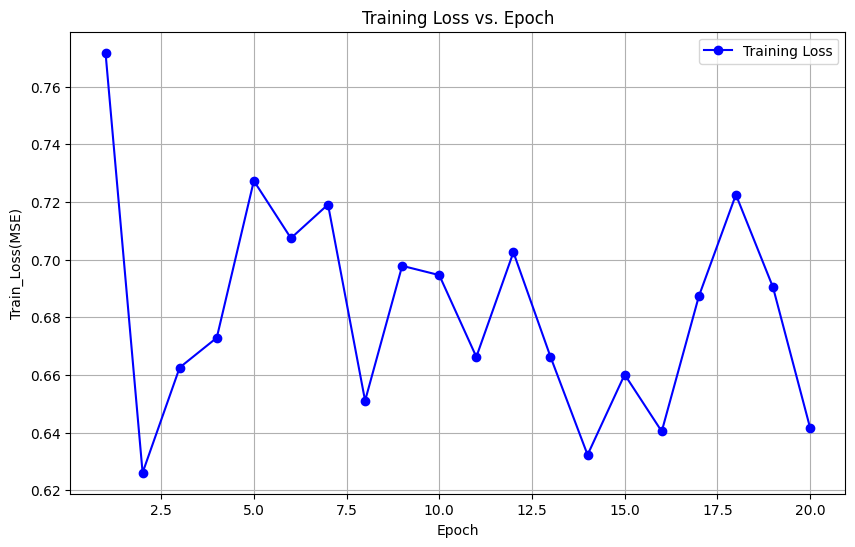

In [38]:
# plot of train_loss vs epoch

# convert the PyTorch tensors train_loss and epoch_arr to NumPy arrays before plotting them
# else error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
train_loss_np = [loss.item() for loss in train_loss]

plt.figure(figsize=(10, 6))
plt.plot(epoch_arr, train_loss_np, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Train_Loss(MSE)')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [53]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()

num_classes = 1
# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([]).reshape(0, num_classes)  # Replace 'num_classes' with the actual number of classes
predicted_val = np.array([]).reshape(0, num_classes)    # Replace 'num_classes' with the actual number of classes
predicted_test = np.array([]).reshape(0, num_classes)

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to('cpu')
    x = x.unsqueeze(1)
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to validate

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to('cpu')
    x = x.unsqueeze(1)
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# predict on the validation data, to see how the model does

for idx, (x, y) in enumerate(test_dataloader):
    x = x.to('cpu')
    x = x.unsqueeze(1)
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_test = np.concatenate((predicted_test, out))


In [55]:
# Get labels for training data
ytrain = train_dataset[:][1]
yval = val_dataset[:][1]
ytest = test_dataset[:][1]

# Create x values for y1, assuming they are just the indices of the data points
xtrain = np.arange(len(ytrain))
xval = np.arange(len(ytrain), len(ytrain) + len(yval))
xtest = np.arange(len(ytrain) + len(yval), len(ytrain) + len(yval) + len(ytest))

Training

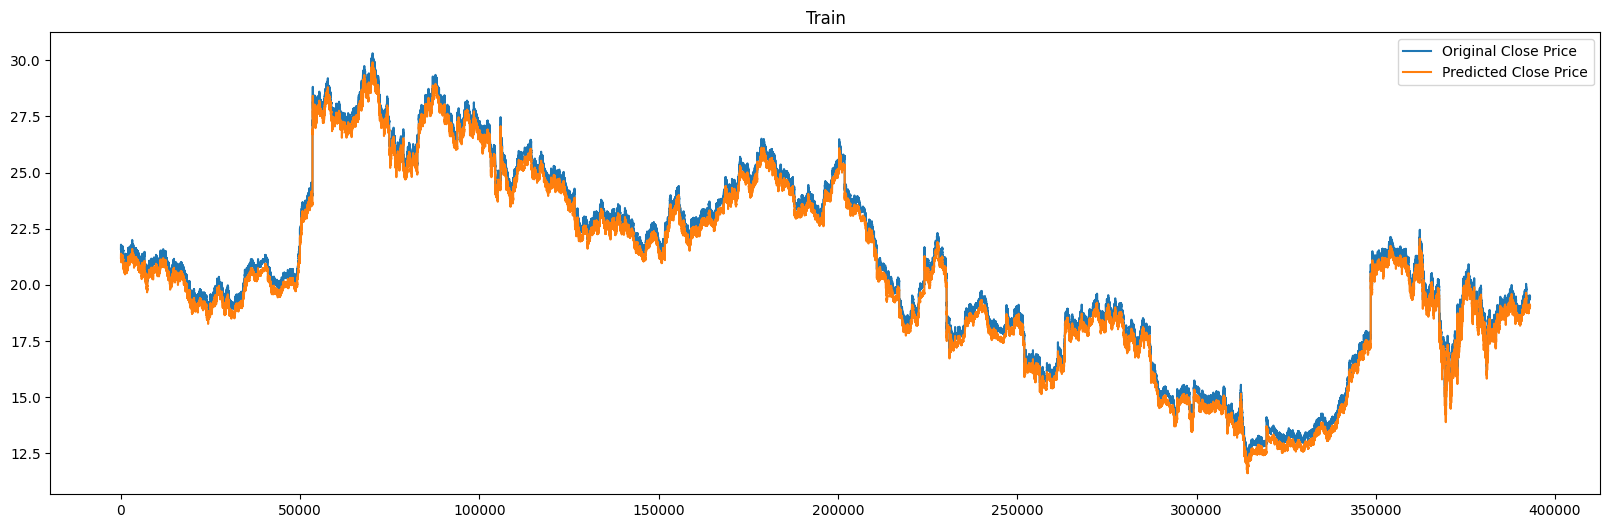

In [102]:
plt.figure(figsize=(20, 6))
# plt.plot(fin_pred_test)
xtrain = np.arange(len(train_dataset[:][1][100:]))
plt.plot(xtrain,stock1_minmax['Close'][:393020], label = 'Original Close Price')
plt.plot(xtrain,predicted_train[:393020],  label = 'Predicted Close Price')
plt.title('Train')
plt.legend()

Validation

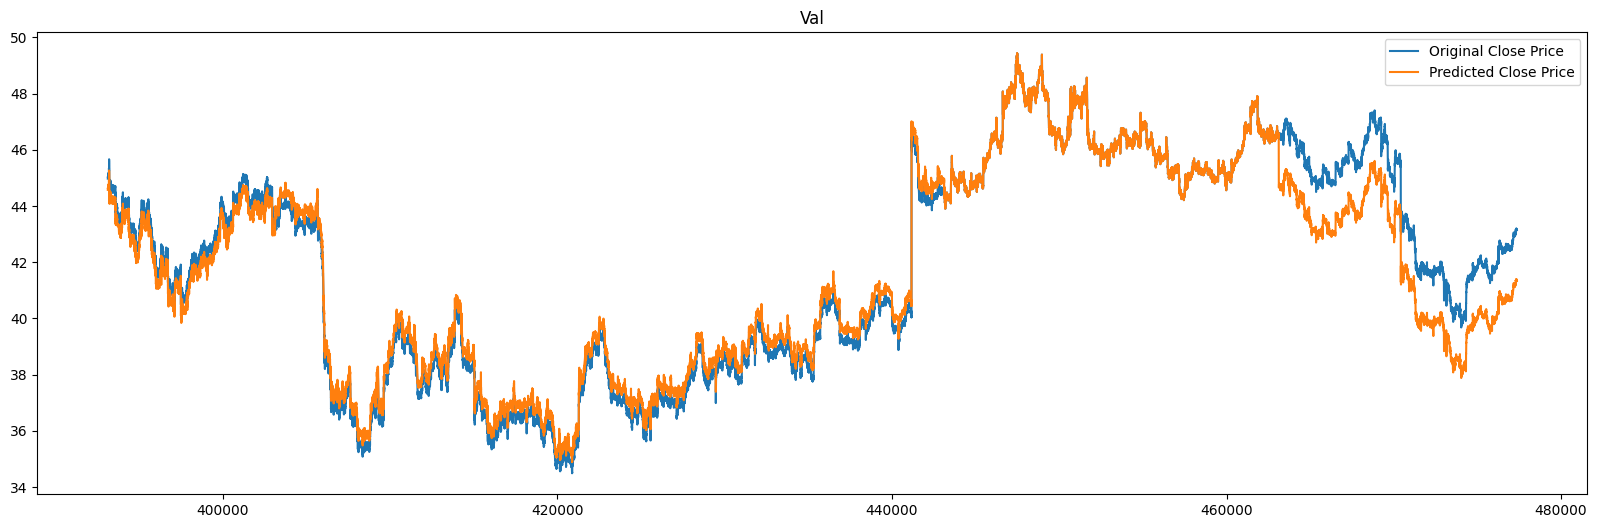

In [103]:
plt.figure(figsize=(20, 6))
# plt.plot(fin_pred_test)
xtrain = np.arange(len(train_dataset[:][1][100:]))
plt.plot(xval,stock1_minmax['Close'][393020:477260], label = 'Original Close Price')
plt.plot(xval,predicted_train[393020:477260], label = 'Predicted Close Price')
plt.title('Val')
plt.legend()

Testing

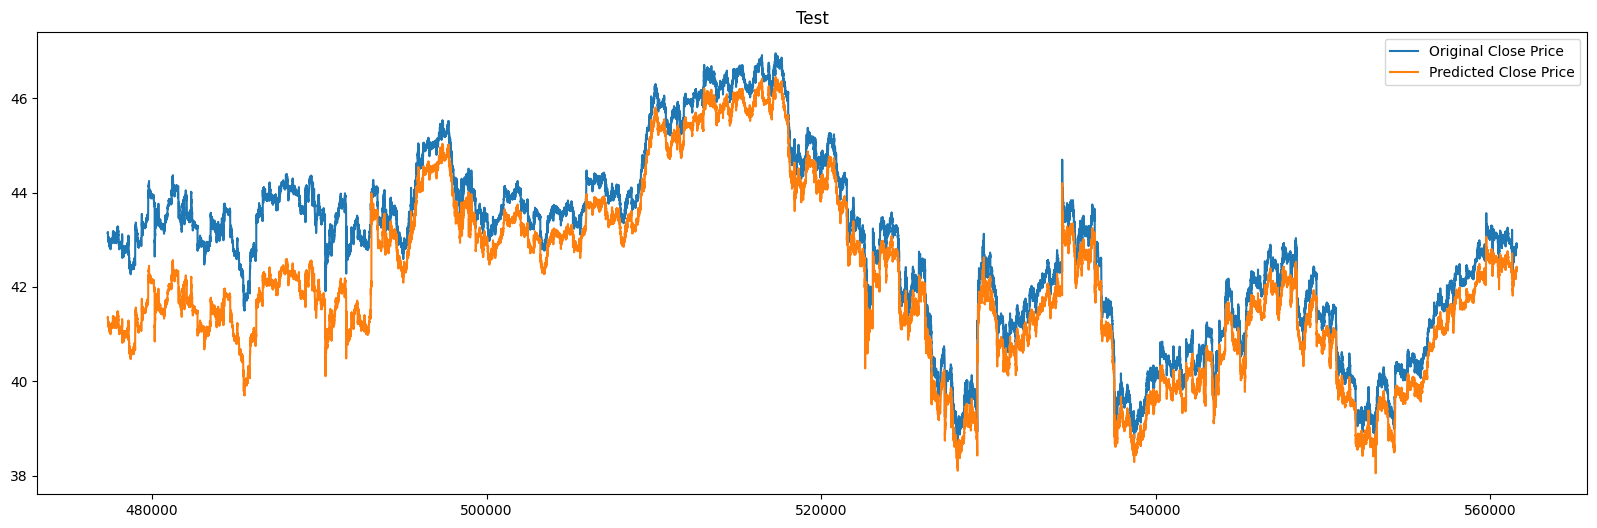

In [105]:
plt.figure(figsize=(20, 6))
# plt.plot(fin_pred_test)
xtrain = np.arange(len(train_dataset[:][1][100:]))
plt.plot(xtest,stock1_minmax['Close'][477260:561500], label = 'Original Close Price')
plt.plot(xtest,predicted_train[477260:561500],  label = 'Predicted Close Price')
plt.title('Test')
plt.legend()

## 7. Trading Module

In [114]:
class TradingModule:
    def __init__(self, initial_balance=100000, commission_rate=0.0002):
        self.balance = initial_balance  # Initial balance in your trading account
        self.commission_rate = commission_rate  # Commission rate (0.02% as 0.0002)
        self.holdings = {}  # Dictionary to store your holdings
        self.bid_ask_spread = {}  # Dictionary to store bid-ask spreads for different assets

    def moving_average_strategy(data, short_window, long_window):
      signals = pd.DataFrame(index=data.index)
      signals['Price'] = data['Close']

      # Create short and long simple moving averages
      signals['Short_SMA'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
      signals['Long_SMA'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

      # Create signals based on moving average crossover
      signals['Signal'] = 0
      signals['Signal'][short_window:] = np.where(signals['Short_SMA'][short_window:] > signals['Long_SMA'][short_window:], 1, 0)

      # Generate buy and sell signals
      signals['Buy_Signal'] = np.where((signals['Signal'] == 1) & (signals['Signal'].shift(1) == 0), 1, 0)
      signals['Sell_Signal'] = np.where((signals['Signal'] == 0) & (signals['Signal'].shift(1) == 1), -1, 0)

      return signals

## 8. Testing the trading module

In [115]:
# Load historical price data (replace with your data loading code)

n_train_samples = 390*30
# Split data into training and testing periods
train_data = prdicted_data.iloc[:n_train_samples]
test_data = prdicted_data.iloc[n_train_samples:]

# Define trading parameters
short_window = 50
long_window = 200

# Apply the trading strategy to the test data
signals = TradingModule.moving_average_strategy(test_data, short_window, long_window)

# Backtest the strategy
initial_cash = 100000  # Starting capital
cash = initial_cash
position = 0  # Number of shares held

for index, signal_row in signals.iterrows():
    if signal_row['Buy_Signal'] == 1:
        # Buy signal: Invest a fixed percentage of cash
        buy_price = signal_row['Price']
        max_investment = 0.2 * cash  # Invest up to 20% of available cash
        shares_to_buy = min(max_investment / buy_price, 1000)  # Limit to 1000 shares per trade
        cash -= shares_to_buy * buy_price
        position += shares_to_buy
    elif signal_row['Sell_Signal'] == -1:
        # Sell signal: Sell all shares
        sell_price = signal_row['Price']
        cash += position * sell_price
        position = 0

# Calculate final portfolio value
final_portfolio_value = cash + (position * test_data['Close'].iloc[-1])

# Compare to buy-and-hold strategy
buy_and_hold_return = (test_data['Close'].iloc[-1] - test_data['Close'].iloc[0]) * (initial_cash / test_data['Close'].iloc[0])

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Buy-and-Hold Return: ${buy_and_hold_return:.2f}")


<ipython-input-114-38673473f121>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Final Portfolio Value: $112868.01
Buy-and-Hold Return: $368961.70


a)Does the price prediction error increase as you go further from the last time on which it
was trained? </br>
- Yes
</br>

b) Can you profitably trade with the bid-ask spread and commissions taken into account?</br>
- Yes, using the above Buy-hold/bid-ask strategies and considering commision rate to be **0.02%** I'm getting a profit of around **12%**  </br>

c) How does your profitability compare to a simple buy-and-hold strategy over long term (e.g.
one or two years)?</br>
-



## References
1. Chatgpt
2. Stackoverflow
3. Investopedia